# Project Energy Disaggregation (ED)


Practical information of the project:

| **Group** | *80 (additional topics!)* |
|-----------|:---------------------------------|
| **Diede Boerman** | *s1864750* |
| **Wouter Hottenhuis** | *s1851322* |


The goal of the project is to analyse the REDD dataset according to interesting questions. The main report is written in a separate PDF file. This file contains the code, output, and some explanation on the steps we conduct to get the results for our report.

First we will import some libraries that we use throughout this notebook.

In [1]:
# Importing necessary libraries
import numpy as np
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import matplotlib
from IPython.display import display
from datetime import datetime
import time
import math
import warnings
warnings.filterwarnings("ignore")
import glob
from sktime.transformations.panel.tsfresh import TSFreshFeatureExtractor
from sklearn.model_selection import train_test_split
import sklearn.metrics
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier, ExtraTreesClassifier, VotingClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.pipeline import make_pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV, cross_val_score, StratifiedKFold, learning_curve
from tsfresh.utilities.dataframe_functions import impute
from tsfresh.feature_selection.selection import select_features


We now read the provided dataset and try to get some feeling for it. 

In [2]:
# https://github.com/minhup/Energy-Disaggregation/blob/master/energy_disaggregation.ipynb

def read_label():
    label = {}
    for i in range(1, 7):
        hi = 'low_freq/house_{}/labels.dat'.format(i)
        label[i] = {}
        with open(hi) as f:
            for line in f:
                splitted_line = line.split(' ')
                label[i][int(splitted_line[0])] = splitted_line[1].strip() + '_' + splitted_line[0]
    return label

# Reading labels of the six houses
labels = read_label()
for i in range(1,7):
    print('House {}: '.format(i), labels[i], '\n')

House 1:  {1: 'mains_1', 2: 'mains_2', 3: 'oven_3', 4: 'oven_4', 5: 'refrigerator_5', 6: 'dishwaser_6', 7: 'kitchen_outlets_7', 8: 'kitchen_outlets_8', 9: 'lighting_9', 10: 'washer_dryer_10', 11: 'microwave_11', 12: 'bathroom_gfi_12', 13: 'electric_heat_13', 14: 'stove_14', 15: 'kitchen_outlets_15', 16: 'kitchen_outlets_16', 17: 'lighting_17', 18: 'lighting_18', 19: 'washer_dryer_19', 20: 'washer_dryer_20'} 

House 2:  {1: 'mains_1', 2: 'mains_2', 3: 'kitchen_outlets_3', 4: 'lighting_4', 5: 'stove_5', 6: 'microwave_6', 7: 'washer_dryer_7', 8: 'kitchen_outlets_8', 9: 'refrigerator_9', 10: 'dishwaser_10', 11: 'disposal_11'} 

House 3:  {1: 'mains_1', 2: 'mains_2', 3: 'outlets_unknown_3', 4: 'outlets_unknown_4', 5: 'lighting_5', 6: 'electronics_6', 7: 'refrigerator_7', 8: 'disposal_8', 9: 'dishwaser_9', 10: 'furance_10', 11: 'lighting_11', 12: 'outlets_unknown_12', 13: 'washer_dryer_13', 14: 'washer_dryer_14', 15: 'lighting_15', 16: 'microwave_16', 17: 'lighting_17', 18: 'smoke_alarms_18'

In [3]:
def read_merge_data(house):
    path = 'low_freq/house_{}/'.format(house)
    file = path + 'channel_1.dat'
    df = pd.read_table(file, sep = ' ', names = ['unix_time', labels[house][1]], 
                                       dtype = {'unix_time': 'int64', labels[house][1]:'float64'}) 
    
    num_apps = len(glob.glob(path + 'channel*'))
    for i in range(2, num_apps + 1):
        file = path + 'channel_{}.dat'.format(i)
        data = pd.read_table(file, sep = ' ', names = ['unix_time', labels[house][i]], 
                                       dtype = {'unix_time': 'int64', labels[house][i]:'float64'})
        df = pd.merge(df, data, how = 'inner', on = 'unix_time')
    df['timestamp'] = df['unix_time'].astype("datetime64[s]")
    df = df.set_index(df['timestamp'].values)
    df.drop(['unix_time','timestamp'], axis=1, inplace=True)
    return df
df = {}

for i in range(1,7):
    df[i] = read_merge_data(i)
    
for i in range(1,7):
    print('House {} data has shape: '.format(i), df[i].shape)
    display(df[i].tail(5))

House 1 data has shape:  (406748, 20)


,mains_1,mains_2,oven_3,oven_4,refrigerator_5,dishwaser_6,kitchen_outlets_7,kitchen_outlets_8,lighting_9,washer_dryer_10,microwave_11,bathroom_gfi_12,electric_heat_13,stove_14,kitchen_outlets_15,kitchen_outlets_16,lighting_17,lighting_18,washer_dryer_19,washer_dryer_20
2011-05-24 19:56:20,235.73,38.65,0.0,0.0,186.0,1.0,26.0,20.0,2.0,0.0,4.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0
2011-05-24 19:56:23,235.03,38.66,0.0,0.0,187.0,0.0,24.0,20.0,2.0,0.0,4.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0
2011-05-24 19:56:27,235.46,38.61,0.0,0.0,190.0,0.0,24.0,20.0,2.0,0.0,4.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0
2011-05-24 19:56:30,235.98,38.77,0.0,0.0,189.0,0.0,24.0,20.0,2.0,0.0,4.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0
2011-05-24 19:56:34,235.29,38.83,0.0,0.0,186.0,0.0,26.0,20.0,2.0,0.0,4.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0


House 2 data has shape:  (316840, 11)


,mains_1,mains_2,kitchen_outlets_3,lighting_4,stove_5,microwave_6,washer_dryer_7,kitchen_outlets_8,refrigerator_9,dishwaser_10,disposal_11
2011-05-22 23:58:54,10.78,252.55,0.0,9.0,0.0,5.0,0.0,2.0,159.0,0.0,0.0
2011-05-22 23:58:57,10.76,253.01,0.0,8.0,0.0,4.0,0.0,2.0,158.0,0.0,0.0
2011-05-22 23:59:01,10.84,252.61,0.0,9.0,0.0,5.0,0.0,2.0,158.0,0.0,0.0
2011-05-22 23:59:04,10.88,253.02,0.0,9.0,0.0,4.0,0.0,2.0,160.0,0.0,0.0
2011-05-22 23:59:08,10.84,252.77,0.0,9.0,0.0,4.0,0.0,2.0,157.0,0.0,0.0


House 3 data has shape:  (376150, 22)


,mains_1,mains_2,outlets_unknown_3,outlets_unknown_4,lighting_5,electronics_6,refrigerator_7,disposal_8,dishwaser_9,furance_10,...,washer_dryer_13,washer_dryer_14,lighting_15,microwave_16,lighting_17,smoke_alarms_18,lighting_19,bathroom_gfi_20,kitchen_outlets_21,kitchen_outlets_22
2011-05-31 00:19:23,15.47,2.23,0.0,1.0,1.0,1130.0,8.0,7.0,3.0,7.0,...,0.0,0.0,1.0,1.0,10.0,0.0,0.0,0.0,0.0,2.5
2011-05-31 00:19:26,15.48,2.23,0.0,1.0,1.0,1136.0,8.0,6.0,3.0,7.0,...,0.0,0.0,1.0,2.0,10.0,0.0,0.0,0.0,0.0,2.5
2011-05-31 00:19:30,15.45,2.23,0.0,1.0,1.0,1139.0,8.0,6.0,3.0,7.0,...,0.0,0.0,1.0,2.0,10.0,0.0,0.0,0.0,0.0,2.5
2011-05-31 00:19:33,15.42,2.23,0.0,1.0,1.0,1138.0,8.0,6.0,3.0,7.0,...,0.0,0.0,1.0,2.0,10.0,0.0,0.0,0.0,0.0,2.5
2011-05-31 00:19:36,15.44,2.23,0.0,1.0,1.0,1134.0,7.0,6.0,3.0,7.0,...,0.0,0.0,1.0,2.0,10.0,0.0,0.0,0.0,0.0,2.5


House 4 data has shape:  (428076, 20)


,mains_1,mains_2,lighting_3,furance_4,kitchen_outlets_5,outlets_unknown_6,washer_dryer_7,stove_8,air_conditioning_9,air_conditioning_10,miscellaeneous_11,smoke_alarms_12,lighting_13,kitchen_outlets_14,dishwaser_15,bathroom_gfi_16,bathroom_gfi_17,lighting_18,lighting_19,air_conditioning_20
2011-06-04 00:45:25,400.95,94.80,178.0,27.0,34.0,4.0,1.0,5.0,0.0,0.0,2.0,0.0,25.0,135.0,0.0,0.0,1.0,0.0,0.0,0.0
2011-06-04 00:45:28,399.17,94.83,177.0,27.0,36.0,4.0,0.0,5.0,0.0,0.0,2.0,0.0,26.0,135.0,0.0,0.0,0.0,0.0,0.0,0.0
2011-06-04 00:45:31,403.36,94.65,173.0,27.0,38.0,3.0,1.0,5.0,0.0,0.0,1.0,0.0,25.0,135.0,0.0,0.0,1.0,0.0,0.0,0.0
2011-06-04 00:45:35,401.11,94.63,174.0,27.0,34.0,4.0,1.0,5.0,0.0,0.0,1.0,0.0,25.0,135.0,0.0,0.0,1.0,0.0,0.0,0.0
2011-06-04 00:45:38,400.24,94.43,175.0,27.0,38.0,4.0,1.0,5.0,0.0,0.0,2.0,0.0,25.0,135.0,0.0,0.0,1.0,0.0,0.0,0.0


House 5 data has shape:  (77451, 26)


,mains_1,mains_2,microwave_3,lighting_4,outlets_unknown_5,furance_6,outlets_unknown_7,washer_dryer_8,washer_dryer_9,subpanel_10,...,lighting_17,refrigerator_18,lighting_19,dishwaser_20,disposal_21,electronics_22,lighting_23,kitchen_outlets_24,kitchen_outlets_25,outdoor_outlets_26
2011-06-01 00:19:59,152.24,37.32,3.0,0.0,3.0,7.0,0.0,0.0,0.0,15.0,...,0.0,0.0,2.0,0.0,0.0,7.5,97.5,0.0,0.0,0.0
2011-06-01 00:20:03,151.72,37.41,3.0,0.0,3.0,7.0,0.0,0.0,0.0,12.5,...,0.0,0.0,2.0,0.0,0.0,5.0,105.0,0.0,0.0,0.0
2011-06-01 00:20:07,151.68,37.39,3.0,0.0,3.0,7.0,0.0,0.0,0.0,12.5,...,0.0,0.0,2.0,0.0,0.0,5.0,115.0,0.0,0.0,0.0
2011-06-01 00:20:10,150.42,37.21,3.0,0.0,3.0,7.0,0.0,0.0,0.0,12.5,...,0.0,1.0,2.0,0.0,0.0,5.0,100.0,0.0,0.0,0.0
2011-06-01 00:20:14,149.29,37.10,3.0,0.0,3.0,7.0,0.0,0.0,0.0,12.5,...,0.0,0.0,2.0,0.0,0.0,5.0,97.5,0.0,0.0,0.0


House 6 data has shape:  (192192, 17)


,mains_1,mains_2,kitchen_outlets_3,washer_dryer_4,stove_5,electronics_6,bathroom_gfi_7,refrigerator_8,dishwaser_9,outlets_unknown_10,outlets_unknown_11,electric_heat_12,kitchen_outlets_13,lighting_14,air_conditioning_15,air_conditioning_16,air_conditioning_17
2011-06-14 01:12:20,19.78,399.61,4.0,3.0,1.0,0.0,3.0,144.0,0.0,87.0,0.0,8.0,0.0,113.0,4.0,0.0,0.0
2011-06-14 01:12:23,19.73,399.66,4.0,3.0,1.0,0.0,3.0,138.0,0.0,87.0,0.0,7.0,1.0,114.0,4.0,0.0,0.0
2011-06-14 01:12:25,19.82,401.65,4.0,3.0,1.0,0.0,4.0,140.0,0.0,87.0,0.0,7.0,1.0,114.0,4.0,0.0,0.0
2011-06-14 01:12:33,19.59,400.11,4.0,3.0,1.0,0.0,3.0,143.0,0.0,87.0,0.0,7.0,1.0,113.0,4.0,0.0,0.0
2011-06-14 01:12:36,19.59,399.47,4.0,3.0,1.0,0.0,3.0,143.0,0.0,87.0,0.0,7.0,0.0,113.0,4.0,0.0,0.0


In the table above, we read five lines of data for each of the six houses. We provide a brief explanation on the outcome for the first house. As we can read, the house has in total 20 channels (indicated by the general category of device of the channel). For each of them, the time and wattage is logged (at a frequency of about once a second for a mains and once every three seconds for the circuits). 

### Functions
Below we made a few functions to transform the data into windows, and to transform the windowed dataframe into a dataframe with one column, with in each cell an array of a time series.

In [4]:
""" IMPROVED VERSION TO ADD EXTRA LABELS OF WEEKDAYS AND AFTERNOON/MORNING ETC."""

def split_a_house_add_labels(df_number, windowlength):
    """This function splits the dataframe in seperate time series"""
    
    # Initialize empty dataframe, with the windows as columns
    merged_df = pd.DataFrame(columns=np.arange(0,windowlength,1))
    merged_df[['partofday','weekday']] = None

    # Remove last 'rest'rows from dataframe to ensure a good fit
    rest = df_number.shape[0]%windowlength
    numberofsplits = ((df_number.shape[0]-rest) / windowlength)
    splitted = np.array_split(df_number.iloc[:-rest,-(df_number.shape[1]):], numberofsplits) 
    
    # Inverse df, make columnnames same as merged_df, and merge
    for dataframe in splitted:
        middlepoint = int(dataframe.shape[0]/2)
#         date = str(df[1].iloc[middlepoint:middlepoint+1,:].index.values[0])[:10]
        hour = str(dataframe.iloc[middlepoint:middlepoint+1,:].index.values[0])[11:13]
        partofday = get_prt_of_the_day(hour)
        weekday = np.is_busday(np.datetime64(str(dataframe.iloc[middlepoint:middlepoint+1,:].index.values[0])[:10]))

        dataframe = dataframe.transpose()
        dataframe.columns = np.arange(0,dataframe.shape[1],1)
        dataframe['partofday'] = partofday
        dataframe['weekday'] = int(weekday)
    
        merged_df = merged_df.append(dataframe)
    
    # Add labels in a seperate column
    merged_df['label'] = merged_df.index
    merged_df['label'] = merged_df['label'].str.split('_').str[:-1].str.join('_') #remove number
    
    return merged_df   

In [5]:
def dataframe_to_numpycell(df):
    
    """This function is needed to place all cells (except the label) into 
        one cell, and then includes the label again. 
        
        This is needed for the use of TSFreshFeatureExtractor"""
    
    dfts = df.drop(['label', 'weekday' , 'partofday'], axis  = 1)
    dfts['TSarray'] = dfts.apply(lambda r: tuple(r), axis=1).apply(np.array)
    dfts['label'] = df['label']
    dfreturn = dfts[['TSarray', 'label']] # weekday and partofday are not returned, as they will be added after featureextractor
    
    return dfreturn

In [6]:
def get_prt_of_the_day(x):
    x = int(x)
    if (x > 6) and (x <= 12):
        return 'Morning'
    elif (x > 12) and (x <= 18):
        return'Afternoon'
    elif (x > 18) and (x <= 24) :
        return 'Evening'
    elif (x <= 6):
        return'Night'


### Quick example of use of these functions

First we make the house data in windows.

In [7]:
house1  = split_a_house_add_labels(df[1], 1800) # windowed dataframe with label, weekday and partofday
house1ts = dataframe_to_numpycell(house1) #only arrays and labels

Now we have a dataframe like this:
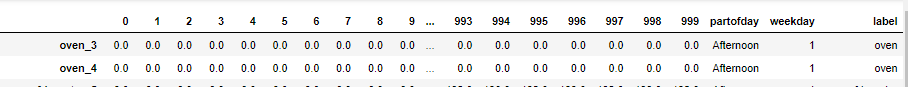

But house1ts has not the features of weekday and part of the day. These will be included, after the features are extracted, in a new dataframe

In [8]:
transformer = TSFreshFeatureExtractor(default_fc_parameters = "efficient", #"efficient" or "minimal" or "comprehensive"
                                      show_warnings = False,
                                     disable_progressbar=False,
                                     impute_function=impute) 
extracted_features = transformer.fit_transform(house1ts.iloc[:,:-1])

Feature Extraction: 100%|██████████████████████████████████████████████████████████| 4500/4500 [26:26<00:00,  2.84it/s]


Laslty, we add the variables from the calendar domain. Than this new dataframe can be used to make a train and test set.

In [9]:
select_features(extracted_features, house1['label'].values)

,TSarray__has_duplicate_min,"TSarray__change_quantiles__f_agg_""var""__isabs_True__qh_0.6__ql_0.4","TSarray__change_quantiles__f_agg_""var""__isabs_False__qh_0.4__ql_0.2","TSarray__change_quantiles__f_agg_""mean""__isabs_True__qh_0.6__ql_0.4","TSarray__change_quantiles__f_agg_""mean""__isabs_True__qh_0.4__ql_0.2","TSarray__change_quantiles__f_agg_""var""__isabs_False__qh_0.6__ql_0.4","TSarray__change_quantiles__f_agg_""mean""__isabs_True__qh_0.2__ql_0.0","TSarray__change_quantiles__f_agg_""mean""__isabs_True__qh_0.8__ql_0.6","TSarray__change_quantiles__f_agg_""var""__isabs_True__qh_0.4__ql_0.2",TSarray__percentage_of_reoccurring_datapoints_to_all_datapoints,...,"TSarray__cwt_coefficients__coeff_0__w_2__widths_(2, 5, 10, 20)",TSarray__ar_coefficient__coeff_5__k_10,"TSarray__fft_coefficient__attr_""real""__coeff_83","TSarray__fft_coefficient__attr_""real""__coeff_41",TSarray__partial_autocorrelation__lag_6,TSarray__autocorrelation__lag_0,"TSarray__fft_coefficient__attr_""real""__coeff_44","TSarray__cwt_coefficients__coeff_13__w_2__widths_(2, 5, 10, 20)","TSarray__fft_coefficient__attr_""imag""__coeff_98",TSarray__partial_autocorrelation__lag_4
0,0.0,0.751963,2.101733,0.975542,0.999748,1.703531,0.658866,1.509027,1.102606,0.314444,...,-0.455732,0.001489,-1546.021856,-26099.803596,-0.015640,1.0,15017.119815,0.027249,-5115.515423,-0.013463
1,0.0,0.005721,0.009759,0.102087,0.078597,0.016106,0.105547,0.629137,0.003601,0.888889,...,-0.021609,0.001491,-303.335810,681.189325,-0.001246,1.0,-359.637270,0.102814,-99.929252,0.012800
2,1.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.999444,...,0.000000,-0.000562,-1.433941,2.265769,-0.000561,1.0,-1.915111,0.000000,1.915111,-0.000559
3,1.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.999444,...,0.000000,-0.000562,0.261321,-1.672827,-0.000561,1.0,-2.445369,0.000000,-2.486305,-0.000559
4,0.0,0.033068,0.000000,0.034241,0.000000,0.034240,0.016092,1.112167,0.000000,0.988333,...,0.000109,0.000407,-2441.222699,1550.225792,0.006608,1.0,1953.154474,0.000219,735.384611,0.016327
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4495,1.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,...,0.000000,0.000000,0.000000,0.000000,0.009667,1.0,0.000000,0.000000,0.000000,0.027609
4496,1.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,...,0.000000,0.000000,0.000000,0.000000,0.009667,1.0,0.000000,0.000000,0.000000,0.027609
4497,1.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,...,0.202553,-0.019264,3.531846,-7.616935,-0.000002,1.0,9.744100,0.000036,5.348841,-0.005019
4498,1.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,...,0.000000,0.000000,0.000000,0.000000,0.009667,1.0,0.000000,0.000000,0.000000,0.027609


In [10]:
extravariables = house1[['weekday', 'partofday']].reset_index()
extracted_features[['weekday', 'partofday']] = extravariables[['weekday', 'partofday']]

In [11]:
X_train, X_test, y_train, y_test = train_test_split(extracted_features, house1['label'], test_size=0.33, random_state=105)
X_train = pd.DataFrame(X_train)
X_test = pd.DataFrame(X_test)

In [12]:
extracted_features

,TSarray__variance_larger_than_standard_deviation,TSarray__has_duplicate_max,TSarray__has_duplicate_min,TSarray__has_duplicate,TSarray__sum_values,TSarray__abs_energy,TSarray__mean_abs_change,TSarray__mean_change,TSarray__mean_second_derivative_central,TSarray__median,...,TSarray__query_similarity_count__query_None__threshold_0.0,"TSarray__matrix_profile__feature_""min""__threshold_0.98","TSarray__matrix_profile__feature_""max""__threshold_0.98","TSarray__matrix_profile__feature_""mean""__threshold_0.98","TSarray__matrix_profile__feature_""median""__threshold_0.98","TSarray__matrix_profile__feature_""25""__threshold_0.98","TSarray__matrix_profile__feature_""75""__threshold_0.98",TSarray__mean_n_absolute_max__number_of_maxima_7,weekday,partofday
0,1.0,0.0,0.0,1.0,612222.98,3.945929e+08,7.112424,0.066609,-0.000114,218.47,...,0.0,5.662523,20.019664,15.233149,15.871039,12.730614,17.781803,1951.535714,1,Afternoon
1,1.0,0.0,0.0,1.0,100979.10,7.501667e+06,0.299761,-0.043986,-0.000097,40.03,...,0.0,2.298602,13.348611,9.313578,10.315033,7.456896,11.910023,122.425714,1,Afternoon
2,0.0,0.0,1.0,1.0,2.50,6.250000e+00,0.002779,0.000000,0.000000,0.00,...,0.0,5.717667,19.287302,14.179385,14.648104,12.062661,16.373516,0.357143,1,Afternoon
3,0.0,0.0,1.0,1.0,2.50,6.250000e+00,0.002779,0.000000,0.000000,0.00,...,0.0,5.717667,19.287302,14.179385,14.648104,12.062661,16.373516,0.357143,1,Afternoon
4,1.0,0.0,0.0,1.0,188031.00,5.806347e+07,1.700389,0.105058,-0.000834,7.00,...,0.0,5.274560,28.888955,20.344958,23.595868,12.632177,26.768986,471.000000,1,Afternoon
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4495,0.0,1.0,1.0,1.0,0.00,0.000000e+00,0.000000,0.000000,0.000000,0.00,...,0.0,5.717667,19.287302,14.179385,14.648104,12.062661,16.373516,0.000000,1,Afternoon
4496,0.0,1.0,1.0,1.0,0.00,0.000000e+00,0.000000,0.000000,0.000000,0.00,...,0.0,5.717667,19.287302,14.179385,14.648104,12.062661,16.373516,0.000000,1,Afternoon
4497,0.0,1.0,1.0,1.0,1863.00,1.989000e+03,0.062257,0.000000,-0.000278,1.00,...,0.0,11.985101,19.254210,16.553468,17.053889,15.161194,18.187982,2.000000,1,Afternoon
4498,0.0,1.0,1.0,1.0,0.00,0.000000e+00,0.000000,0.000000,0.000000,0.00,...,0.0,5.717667,19.287302,14.179385,14.648104,12.062661,16.373516,0.000000,1,Afternoon


## Large example = full house data

First combine all houses

In [13]:
totalhouse = split_a_house_add_labels(df[1], 1800)
for i in range(2, 7):
    totalhouse = totalhouse.append(split_a_house_add_labels(df[i], 1800))

After that, we will delete the rows which we are not interested in, or which are undersampled. This is out of the scope of this project

In [14]:
totalhouse['label'].value_counts()

lighting            3160
kitchen_outlets     2440
mains               1990
washer_dryer        1696
outlets_unknown     1202
bathroom_gfi        1056
air_conditioning    1029
dishwaser            995
refrigerator         758
stove                744
microwave            652
furance              488
oven                 450
smoke_alarms         445
disposal             427
electric_heat        417
electronics          357
miscellaeneous       237
subpanel              86
outdoor_outlets       43
Name: label, dtype: int64

We drop everything with lower than 450 observations, and the mains:

In [15]:
droplist = ['smoke_alarms', 'disposal', 'electric_heat', 'electronics', 
            'miscellaeneous', 'subpanel', 'outdoor_outlets', 'mains']
totalhouse = totalhouse[~totalhouse['label'].isin(droplist)]

In [16]:
totalhouse['label'].value_counts()

lighting            3160
kitchen_outlets     2440
washer_dryer        1696
outlets_unknown     1202
bathroom_gfi        1056
air_conditioning    1029
dishwaser            995
refrigerator         758
stove                744
microwave            652
furance              488
oven                 450
Name: label, dtype: int64

Now we make a pandas dataframe with the time series in one cell for the featureextractor.

In [17]:
totalhousets = dataframe_to_numpycell(totalhouse)

In [18]:
transformer = TSFreshFeatureExtractor(default_fc_parameters = "efficient", #"efficient" or "minimal" or "comprehensive"
                                      show_warnings = False,
                                     disable_progressbar=False,
                                     impute_function=impute) 
extracted_features = transformer.fit_transform(totalhousets.iloc[:,:-1])

Feature Extraction: 100%|██████████████████████████████████████████████████████| 14670/14670 [1:21:48<00:00,  2.99it/s]


We again include the two earlier created variables.

In [19]:
extravariables = totalhouse[['weekday', 'partofday']].reset_index()
extracted_features[['weekday', 'partofday']] = extravariables[['weekday', 'partofday']]
extracted_features.shape

(14670, 785)

In [20]:
extracted_features.shape

(14670, 785)

This contains far too much features. Therefore we made a list for feachers that we should at least include.

In [21]:
includedfeatures = ['partofday',
 'TSarray__absolute_maximum',
 'TSarray__agg_autocorrelation__f_agg_"mean"__maxlag_40',
 'TSarray__augmented_dickey_fuller__attr_"pvalue"__autolag_"AIC"',
 'TSarray__benford_correlation',
 'TSarray__cid_ce__normalize_True',
 'TSarray__count_above_mean',
 'TSarray__fft_aggregated__aggtype_"centroid"',
 'TSarray__fft_aggregated__aggtype_"kurtosis"',
 'TSarray__fft_aggregated__aggtype_"skew"',
 'TSarray__fft_aggregated__aggtype_"variance"',
 'TSarray__fourier_entropy__bins_10',
 'TSarray__fourier_entropy__bins_100',
 'TSarray__fourier_entropy__bins_2',
 'TSarray__fourier_entropy__bins_3',
 'TSarray__fourier_entropy__bins_5',
 'TSarray__maximum',
 'TSarray__mean',
 'TSarray__median',
 'TSarray__minimum',
 'TSarray__quantile__q_0.2',
 'TSarray__quantile__q_0.8',
 'TSarray__root_mean_square',
 'TSarray__skewness',
 'TSarray__spkt_welch_density__coeff_2',
 'TSarray__spkt_welch_density__coeff_5',
 'TSarray__spkt_welch_density__coeff_8',
 'TSarray__standard_deviation',
 'TSarray__sum_values',
 'TSarray__value_count__value_0',
 'TSarray__variance',
 'weekday'] 

In [22]:
extracted_features = extracted_features[np.intersect1d(extracted_features.columns, includedfeatures)]

Making dummy variables for the weekday variable, which has 4 categorical levels: morning, afternoon, evening and night.

In [23]:
extracted_features = pd.get_dummies(extracted_features, drop_first=True)

In [24]:
X_train, X_test, y_train, y_test = train_test_split(extracted_features, totalhouse['label'], test_size=0.33, random_state=105)
X_train = pd.DataFrame(X_train)
X_test = pd.DataFrame(X_test)

## Making classifiers for large example

In [25]:
# Partly from https://github.com/18D070001/Electrical-Devices-Identification-Model/blob/master/Electrical_Devices_Identification_Model.ipynb

random_state = 105
classifiers = []
classifiers.append(SVC(random_state=random_state))
classifiers.append(DecisionTreeClassifier(random_state=random_state))
classifiers.append(AdaBoostClassifier(DecisionTreeClassifier(random_state=random_state),random_state=random_state,learning_rate=0.1))
classifiers.append(RandomForestClassifier(random_state=random_state))
classifiers.append(ExtraTreesClassifier(random_state=random_state))
classifiers.append(GradientBoostingClassifier(random_state=random_state))
classifiers.append(MLPClassifier(random_state=random_state))
classifiers.append(KNeighborsClassifier())
classifiers.append(LinearDiscriminantAnalysis())



In [26]:
start_time = datetime.now()
kfold = StratifiedKFold(n_splits=5)
cv_results = []
for classifier in classifiers :
    cv_results.append(cross_val_score(classifier, X = X_train, y = y_train, scoring = "accuracy", 
                                      cv = kfold, n_jobs=4)) #error_score="raise" could be added to troubleshoot
end_time = datetime.now()
print('Duration: {}'.format(end_time - start_time))

Duration: 0:02:49.249682


In [27]:
cv_means = []
cv_std = []
for cv_result in cv_results:
    cv_means.append(cv_result.mean())
    cv_std.append(cv_result.std())

   CrossValMeans  CrossValerrors                   Algorithm
0       0.246949        0.010944                         SVC
1       0.546396        0.007240                DecisionTree
2       0.559622        0.015309                    AdaBoost
3       0.617012        0.004339                RandomForest
4       0.617317        0.006614                  ExtraTrees
5       0.586690        0.008162            GradientBoosting
6       0.281946        0.020736     MultipleLayerPerceptron
7       0.441390        0.009397                 KNeighboors
8       0.374542        0.006404  LinearDiscriminantAnalysis


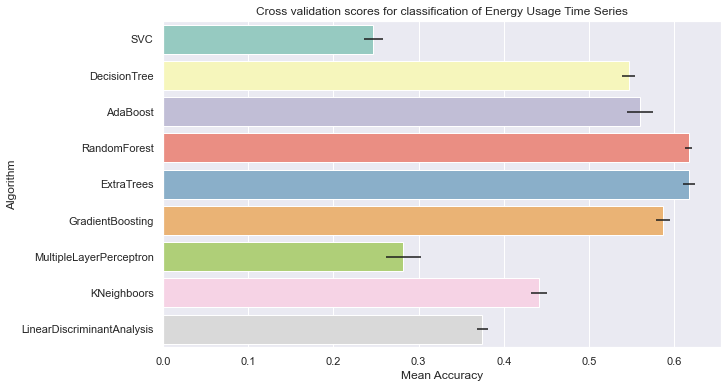

In [28]:
cv_res = pd.DataFrame({"CrossValMeans":cv_means,"CrossValerrors": cv_std,"Algorithm":["SVC","DecisionTree","AdaBoost",
"RandomForest","ExtraTrees","GradientBoosting","MultipleLayerPerceptron","KNeighboors","LinearDiscriminantAnalysis"]})

sns.set(rc={'figure.figsize':(10,6)})

g = sns.barplot("CrossValMeans","Algorithm",data = cv_res, palette="Set3",orient = "h",**{'xerr':cv_std})
g.set_xlabel("Mean Accuracy")
g = g.set_title("Cross validation scores for classification of Energy Usage Time Series") 
print(cv_res)

THIS WAS WITH ALL FEATURES (400 or so)

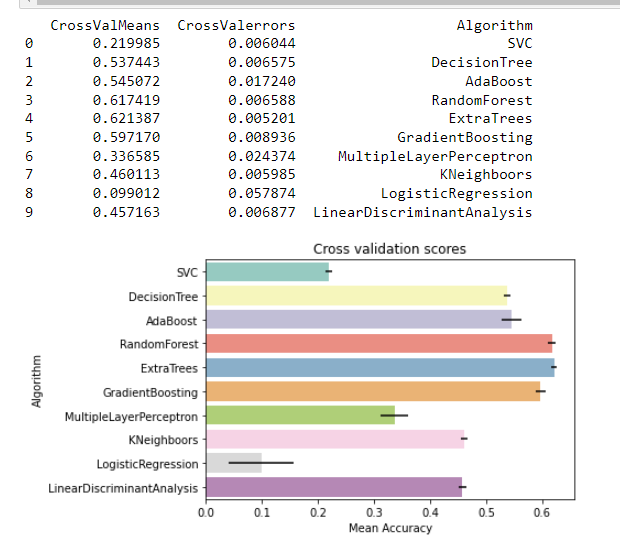

Now these Cross Validated errors look promising. That is because the algorithms perform more or less the same for different folds of the data. That means that it is not sensitive to overfitting.

In [150]:
print(classifiers[3])
classifiers[4].fit(X_train, y_train)
y_pred = list(classifiers[4].predict(X_test))


RandomForestClassifier(random_state=105)


In [151]:
y_test.unique()

array(['washer_dryer', 'oven', 'refrigerator', 'kitchen_outlets',
       'lighting', 'dishwaser', 'bathroom_gfi', 'outlets_unknown',
       'stove', 'microwave', 'air_conditioning', 'furance'], dtype=object)

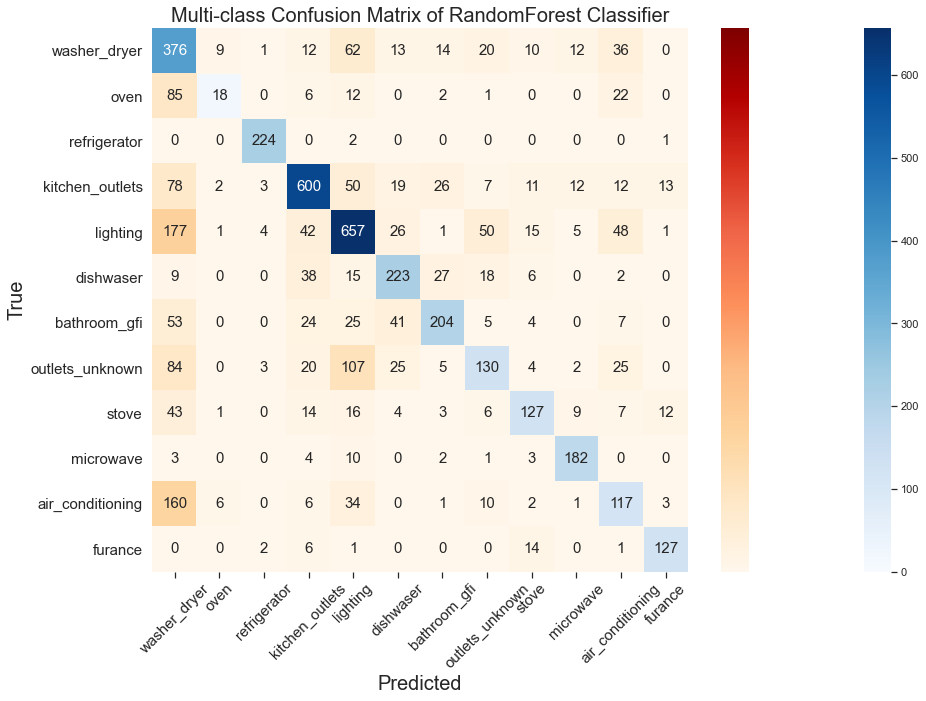

In [153]:
labelss = y_test.unique()
cm = sklearn.metrics.confusion_matrix(y_test, y_pred, labels=labelss)

# Plot confusion matrix in a beautiful manner
fig = plt.figure(figsize=(15, 10))
ax= plt.subplot()
# sns.heatmap(cm, annot=True, ax = ax, fmt = 'd'); #annot=True to annotate cells

vmin = np.min(cm)
vmax = np.max(cm)
off_diag_mask = np.eye(*cm.shape, dtype=bool)

# fig = plt.figure()
sns.heatmap(cm, ax = ax, annot=True, mask=~off_diag_mask, cmap='Blues', vmin=vmin, vmax=vmax, fmt = 'g', annot_kws={"fontsize":15})
sns.heatmap(cm, ax = ax, annot=True, mask=off_diag_mask, cmap='OrRd', vmin=vmin, vmax=vmax, cbar_kws=dict(ticks=[]), fmt = 'g', annot_kws={"fontsize":15})

# labels, title and ticks
ax.set_xlabel('Predicted', fontsize=20)
ax.xaxis.set_label_position('bottom')
plt.xticks(rotation=45)
ax.xaxis.set_ticklabels(labelss, fontsize = 15)
ax.xaxis.tick_bottom()

ax.set_ylabel('True', fontsize=20)
ax.yaxis.set_ticklabels(labelss, fontsize = 15)
plt.yticks(rotation=0)

plt.title('Multi-class Confusion Matrix of RandomForest Classifier', fontsize=20)

plt.savefig('confusion matrix.png')
plt.show()

### Testing on all algorithms

In [32]:
acc = []
f1 = []
precision = []
recall = []
for classifier in classifiers:
    print(classifier)
    classifier.fit(X_train, y_train)
    y_pred = list(classifier.predict(X_test))
    acc.append(sklearn.metrics.accuracy_score(y_test, y_pred))
    f1.append(sklearn.metrics.f1_score(y_test, y_pred, average = 'weighted'))
    precision.append(sklearn.metrics.precision_score(y_test, y_pred, average = 'weighted'))
    recall.append(sklearn.metrics.recall_score(y_test, y_pred, average = 'weighted'))

SVC(random_state=105)
DecisionTreeClassifier(random_state=105)
AdaBoostClassifier(base_estimator=DecisionTreeClassifier(random_state=105),
                   learning_rate=0.1, random_state=105)
RandomForestClassifier(random_state=105)
ExtraTreesClassifier(random_state=105)
GradientBoostingClassifier(random_state=105)
MLPClassifier(random_state=105)
KNeighborsClassifier()
LinearDiscriminantAnalysis()


In [33]:
df = pd.DataFrame({'Accuracy': acc, 
                  'F1-score': f1}, 
                  index = ["SVC","DecisionTree","AdaBoost", "RandomForest","ExtraTrees",
                           "GradientBoosting","MultipleLayerPerceptron","KNeighboors","LinearDiscriminantAnalysis"])

df = df.sort_values('Accuracy')

<Figure size 1080x1440 with 0 Axes>

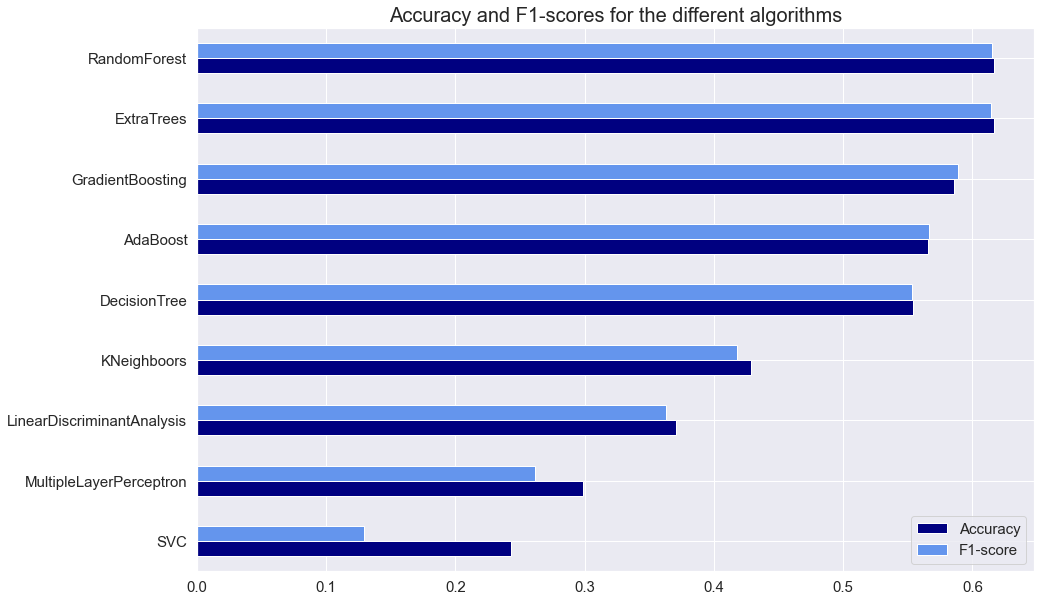

In [34]:
plt.figure(figsize=(15, 20))
ax = df.plot.barh(rot=0, figsize = (15,10), fontsize = 15, color =['navy', 'cornflowerblue'])
plt.legend(loc=4, prop={'size': 15})
plt.title('Accuracy and F1-scores for the different algorithms', fontsize=20)
plt.show()

## Splitting data - combining two models
We split the full dataset on basis on the variable weekday. This will let us investigate whether we can fit two different models based on this split, and if it can outperform the other models.


In [35]:
df_week = extracted_features[extracted_features['weekday_1']==1]
df_weekend = extracted_features[extracted_features['weekday_1']==0]

totalhouse_week = totalhouse[totalhouse['weekday']==1]
totalhouse_week_label = totalhouse_week['label']

totalhouse_weekend = totalhouse[totalhouse['weekday']==0]
totalhouse_weekend_label = totalhouse_weekend['label']

In [36]:
X_trainweek, X_testweek, y_trainweek, y_testweek = train_test_split(df_week, totalhouse_week_label, test_size=0.33, random_state=105)
X_trainweek = pd.DataFrame(X_trainweek)
X_testweek = pd.DataFrame(X_testweek)

X_trainweekend, X_testweekend, y_trainweekend, y_testweekend = train_test_split(df_weekend, totalhouse_weekend_label, test_size=0.33, random_state=105)
X_trainweekend = pd.DataFrame(X_trainweekend)
X_testweekend = pd.DataFrame(X_testweekend)

In [37]:
accweek = []
f1week = []

accweekend = []
f1weekend = []


for classifier in classifiers:
    # For week
    classifier.fit(X_trainweek, y_trainweek)
    y_predweek = list(classifier.predict(X_testweek))
    accweek.append(sklearn.metrics.accuracy_score(y_testweek, y_predweek))
    f1week.append(sklearn.metrics.f1_score(y_testweek, y_predweek, average = 'weighted'))
    
     # For weekend
    classifier.fit(X_trainweekend, y_trainweekend)
    y_predweekend = list(classifier.predict(X_testweekend))
    accweekend.append(sklearn.metrics.accuracy_score(y_testweekend, y_predweekend))
    f1weekend.append(sklearn.metrics.f1_score(y_testweekend, y_predweekend, average = 'weighted'))

In [38]:
df = pd.DataFrame({'Accuracy week': accweek,
                   'Accuracy weekend': accweekend,
                  'F1-score week': f1week,
                  'F1-score weekend': f1weekend}, 
                  index = ["SVC","DecisionTree","AdaBoost", "RandomForest","ExtraTrees",
                           "GradientBoosting","MultipleLayerPerceptron","KNeighboors","LinearDiscriminantAnalysis"])

df = df.sort_values('Accuracy week')

In [39]:
df = df.iloc[7:9,0:2]

In [40]:
df = df.transpose()
df

,RandomForest,ExtraTrees
Accuracy week,0.619584,0.620146
Accuracy weekend,0.584627,0.570652


<Figure size 1080x720 with 0 Axes>

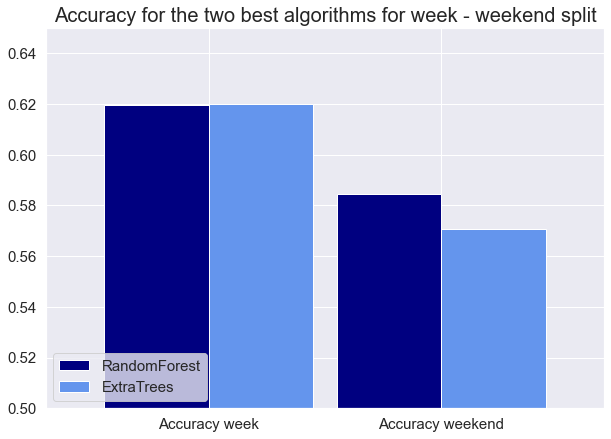

In [122]:
plt.figure(figsize=(15, 10))
ax = df.plot.bar(rot=0, figsize = (10,7), fontsize = 15, color =['navy', 'cornflowerblue'], width= 0.9)
plt.ylim(0.5,0.65)
plt.legend(loc=3, prop={'size': 15})
plt.title('Accuracy for the two best algorithms for week - weekend split', fontsize=20)
plt.show()

In [69]:
y_pred1 = []
y_pred2 = []



 # For weekend
classifiers[3].fit(X_trainweekend, y_trainweekend)
y_pred1 = list(classifiers[3].predict(X_testweekend))

        
# For week
classifiers[4].fit(X_trainweek, y_trainweek)
y_pred2 = list(classifiers[4].predict(X_testweek))


In [66]:
y_pred1 = []
y_pred2 = []

for classifier in classifiers:
    print(classifiers[4])
    if classifier == RandomForestClassifier():
        print("ÿes")
         # For weekend
        classifier.fit(X_trainweekend, y_trainweekend)
        y_pred1 = list(classifier.predict(X_testweekend))
#         accweekend.append(sklearn.metrics.accuracy_score(y_testweekend, y_pred1))
#         f1weekend.append(sklearn.metrics.f1_score(y_testweekend, y_pred1, average = 'weighted'))

    if classifier == "ExtraTreesClassifier(random_state=105)":
        
        # For week
        classifier.fit(X_trainweek, y_trainweek)
        y_pred2 = list(classifier.predict(X_testweek))
#         accweek.append(sklearn.metrics.accuracy_score(y_testweek, y_predweek))
#         f1week.append(sklearn.metrics.f1_score(y_testweek, y_predweek, average = 'weighted'))

ExtraTreesClassifier(random_state=105)
ExtraTreesClassifier(random_state=105)
ExtraTreesClassifier(random_state=105)
ExtraTreesClassifier(random_state=105)
ExtraTreesClassifier(random_state=105)
ExtraTreesClassifier(random_state=105)
ExtraTreesClassifier(random_state=105)
ExtraTreesClassifier(random_state=105)
ExtraTreesClassifier(random_state=105)


In [73]:
len(y_pred1), len(y_testweekend)

(1288, 1288)

In [89]:
len(y_pred2), len(y_testweek)

(3554, 3554)

In [98]:
totaly_pred = y_pred1 + y_pred2
len(totaly_pred)

4842

In [107]:
totaly_test = list(y_testweekend) + list(y_testweek)
len(totaly_test)

4842

In [108]:
len(totaly_test), len(totaly_pred)

(4842, 4842)

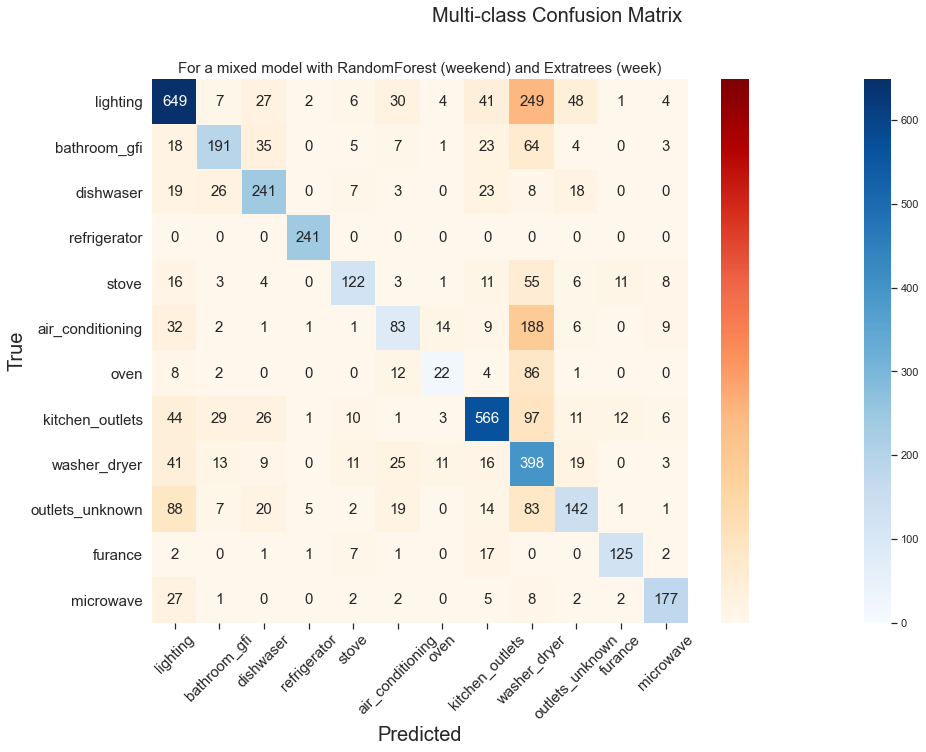

In [128]:
labelss = list(set(totaly_test))

cm = sklearn.metrics.confusion_matrix(totaly_test, totaly_pred, labels=labelss)

# Plot confusion matrix in a beautiful manner
fig = plt.figure(figsize=(15, 10))
ax= plt.subplot()
# sns.heatmap(cm, annot=True, ax = ax, fmt = 'd'); #annot=True to annotate cells

vmin = np.min(cm)
vmax = np.max(cm)
off_diag_mask = np.eye(*cm.shape, dtype=bool)

# fig = plt.figure()
sns.heatmap(cm, ax = ax, annot=True, mask=~off_diag_mask, cmap='Blues', vmin=vmin, vmax=vmax, fmt = 'g', annot_kws={"fontsize":15})
sns.heatmap(cm, ax = ax, annot=True, mask=off_diag_mask, cmap='OrRd', vmin=vmin, vmax=vmax, cbar_kws=dict(ticks=[]), fmt = 'g', annot_kws={"fontsize":15})

# labels, title and ticks
ax.set_xlabel('Predicted', fontsize=20)
ax.xaxis.set_label_position('bottom')
plt.xticks(rotation=45)
ax.xaxis.set_ticklabels(labelss, fontsize = 15)
ax.xaxis.tick_bottom()

ax.set_ylabel('True', fontsize=20)
ax.yaxis.set_ticklabels(labelss, fontsize = 15)
plt.yticks(rotation=0)
plt.suptitle('Multi-class Confusion Matrix', fontsize=20)

plt.title('For a mixed model with RandomForest (weekend) and Extratrees (week)', fontsize=15)

plt.savefig('confusion matrix.png')
plt.show()

In [117]:
print(sklearn.metrics.accuracy_score(totaly_test, totaly_pred))


0.610698058653449


In [112]:
df

,RandomForest,ExtraTrees
Accuracy week,0.619584,0.620146
Accuracy weekend,0.584627,0.570652


In [114]:
len(y_testweek), len(y_testweekend)

(3554, 1288)

In [130]:
abc = totalhouse['label'].value_counts()

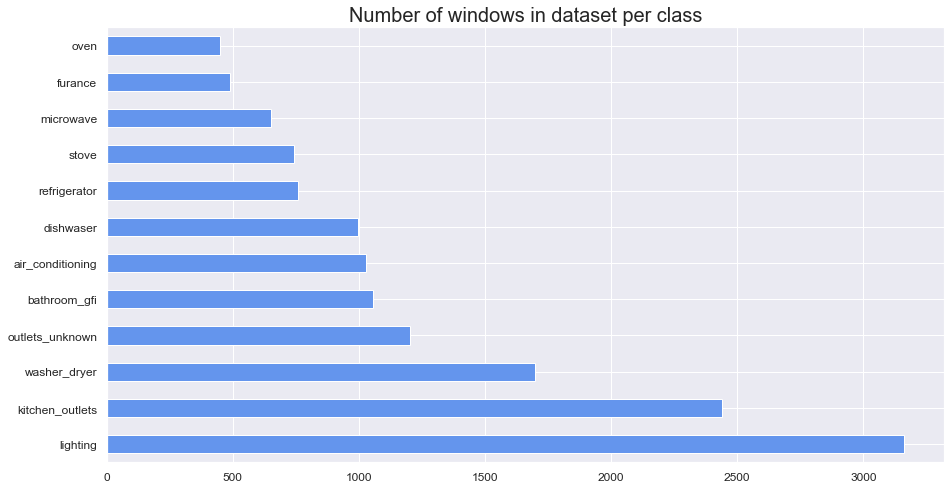

In [147]:
# abc.plot.bar()

plt.figure(figsize=(5, 15))
ax = abc.plot.barh(rot=0, figsize = (15,8), fontsize = 12, color =['cornflowerblue'])
plt.title('Number of windows in dataset per class', fontsize=20)
plt.show()